In [1]:
import logging
import torch
import io
from torchtext.utils import download_from_url, extract_archive, unicode_csv_reader
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import Vocab
from tqdm import tqdm

URLS = {
    'Smoking_Status':
        'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms'
}


def _csv_iterator(data_path, ngrams, yield_cls=False):
    tokenizer = get_tokenizer("basic_english")
    with io.open(data_path, encoding="utf8") as f:
        reader = unicode_csv_reader(f)
        for row in reader:
            tokens = ' '.join(row[1:])
            tokens = tokenizer(tokens)
            if yield_cls:
                #yield int(row[0]) - 1, ngrams_iterator(tokens, ngrams)
                yield int(row[0]), ngrams_iterator(tokens, ngrams)
            else:
                yield ngrams_iterator(tokens, ngrams)


def _create_data_from_iterator(vocab, iterator, include_unk):
    data = []
    labels = []
    with tqdm(unit_scale=0, unit='lines') as t:
        for cls, tokens in iterator:
            if include_unk:
                tokens = torch.tensor([vocab[token] for token in tokens])
            else:
                token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token]
                                        for token in tokens]))
                tokens = torch.tensor(token_ids)
            if len(tokens) == 0:
                logging.info('Row contains no tokens.')
            data.append((cls, tokens))
            labels.append(cls)
            t.update(1)
    return data, set(labels)


class TextClassificationDataset(torch.utils.data.Dataset):
    """Defines an abstract text classification datasets.
       Currently, we only support the following datasets:
             - AG_NEWS
             - SogouNews
             - DBpedia
             - YelpReviewPolarity
             - YelpReviewFull
             - YahooAnswers
             - AmazonReviewPolarity
             - AmazonReviewFull
    """

    def __init__(self, vocab, data, labels):
        """Initiate text-classification dataset.
        Arguments:
            vocab: Vocabulary object used for dataset.
            data: a list of label/tokens tuple. tokens are a tensor after
                numericalizing the string tokens. label is an integer.
                [(label1, tokens1), (label2, tokens2), (label2, tokens3)]
            label: a set of the labels.
                {label1, label2}
        Examples:
            See the examples in examples/text_classification/
        """

        super(TextClassificationDataset, self).__init__()
        self._data = data
        self._labels = labels
        self._vocab = vocab

    def __getitem__(self, i):
        return self._data[i]

    def __len__(self):
        return len(self._data)

    def __iter__(self):
        for x in self._data:
            yield x

    def get_labels(self):
        return self._labels

    def get_vocab(self):
        return self._vocab


def _setup_datasets(dataset_name, root='.data', ngrams=1, vocab=None, include_unk=False):
    #dataset_tar = download_from_url(URLS[dataset_name], root=root)
    #extracted_files = extract_archive(dataset_tar)
    rootPath =root
    extracted_files = [rootPath+'check.csv']   
    for fname in extracted_files:
        if fname.endswith('check.csv'):
            train_csv_path = fname
        

    if vocab is None:
        print('Building Vocab based on {}'.format(train_csv_path))
        vocab = build_vocab_from_iterator(_csv_iterator(train_csv_path, ngrams))
    else:
        if not isinstance(vocab, Vocab):
            raise TypeError("Passed vocabulary is not of type Vocab")
    print('Vocab has {} entries'.format(len(vocab)))
    
    print('Creating training data')
    train_data, train_labels = _create_data_from_iterator(
        vocab, _csv_iterator(train_csv_path, ngrams, yield_cls=True), include_unk)
    
    return (TextClassificationDataset(vocab, train_data, train_labels))


def Smoking_Status(*args, **kwargs):
    """ Defines Smoking_Status datasets.
        The labels includes:
            - 0 : UNKNOWN
            - 1 : NON-SMOKER
            - 2 : PAST SMOKER
            - 3 : CURRENT SMOKER
    Create supervised learning dataset: Smoking_Status
    Separately returns the training and test dataset
    Arguments:
        root: Directory where the datasets are saved. Default: ".data"
        ngrams: a contiguous sequence of n items from s string text.
            Default: 1
        vocab: Vocabulary used for dataset. If None, it will generate a new
            vocabulary based on the train data set.
        include_unk: include unknown token in the data (Default: False)
    Examples:
        >>> train_dataset, test_dataset = torchtext.datasets.Smoking_Status(ngrams=3)
    """

    return _setup_datasets(*(("Smoking_Status",) + args), **kwargs)


DATASETS = {
    'Smoking_Status': Smoking_Status
}


LABELS = {
    'Smoking_Status': {0: 'UNKNOWN',
                1: 'NON-SMOKER',
                2: 'PAST SMOKER',
                3: 'CURRENT SMOKER'}
}


In [2]:
import os
import pandas as pd
import numpy as np

PATH = os.path.abspath(os.getcwd())
datasetPath = PATH+"/Case_Presentation/"
TraindatasetPath = datasetPath+"train/"
TestdatasetPath = datasetPath+"test/"


def GetFile(filePath):
    #Creat Checking file
    CLASSNAME = []
    CLASSNAMES = []
    INFO = []
    FileList = os.listdir(filePath)

    for i in range(len(FileList)):
        filename = FileList[i]
        tmpName = filename.split("_",1)[0]
        classN = ClassName.index(tmpName)
        try:
            classN = ClassName.index(tmpName)
            CLASSNAMES.append(tmpName)
            CLASSNAME.append(classN)

            file = open(TraindatasetPath+filename,'r')
            info = file.read()
            file.close()
            INFO.append(info)

        except :
            print("except {}".format(tmpName))

    df = pd.DataFrame({'label1':CLASSNAME,'label2':CLASSNAMES,'text':INFO})
    df.to_csv(datasetPath+"check.csv",index=False,sep=',',header=False)
    return df.index.size

def GetSingleFile(filePath,filename):
    #Creat Checking file
    CLASSNAME = []
    CLASSNAMES = []
    INFO = []
    
    CLASSNAME.append(0)
    CLASSNAMES.append(filename)

    file = open(filePath+filename,'r')
    info = file.read()
    file.close()
    INFO.append(info)

    df = pd.DataFrame({'label1':CLASSNAME,'label2':CLASSNAMES,'text':INFO})
    df.to_csv(datasetPath+"check.csv",index=False,sep=',',header=False)
    return df.index.size
    

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
    
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label
    


40lines [00:00, 2416.49lines/s]
40lines [00:00, 1202.44lines/s]

Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 14153 entries
Creating training data


[2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2]
[0 1 2 3 0 2 3 0 2 3 0 0 3 1 1 3 0 1 0 2 2 2 0 3 2 0 1 3 1 0 1 2 3 2 1 3 1
 3 1 2]
Confusion matrix, without normalization
[[2 1 7 0]
 [0 2 8 0]
 [0 2 8 0]
 [1 1 8 0]]


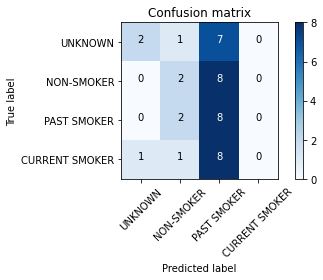

In [4]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
ClassName = ['UNKNOWN', 'NON-SMOKER', 'PAST SMOKER', 'CURRENT SMOKER']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = torch.load('Bestmodel-1.pkl').to(device)

SIZE = GetFile(TraindatasetPath)
NGRAMS = 2
data = DATASETS['Smoking_Status'](root=datasetPath, ngrams=NGRAMS, vocab=None)
BATCH_SIZE = SIZE

data = DataLoader(data, batch_size=BATCH_SIZE, collate_fn=generate_batch)    

for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            
out = output.cpu().numpy().squeeze().tolist()
y_pred = []

for i in range(len(out)):
    y_pred.append(out[i].index(max(out[i])))

print(y_pred)
y_true = cls.cpu().numpy()
print(y_true)  

plt.figure()            
cnf_matrix = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(cnf_matrix, classes=ClassName,normalize=False,
                    title="Confusion matrix")

plt.show()
            

[0.3, 0.3, 0.315, 0.237]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


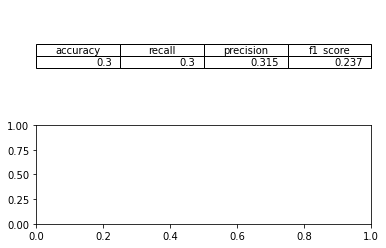

In [5]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

Info = []
Info.append(round(accuracy_score(y_true, y_pred),3))
Info.append(round(recall_score(y_true, y_pred, average='macro'),3))
Info.append(round(precision_score(y_true, y_pred, average='macro'),3))
Info.append(round(f1_score(y_true, y_pred, average='macro'),3))

print(Info)

fig, axs =plt.subplots(2,1)
clust_data = []
clust_data.append(Info)
collabel=("accuracy", "recall", "precision" , "f1_score" )
axs[0].axis('tight')
axs[0].axis('off')
the_table = axs[0].table(cellText=clust_data,colLabels=collabel,loc='center')


In [6]:
from torch.utils.data import DataLoader
fdata=open(datasetPath+"result.txt",'w+') 

ClassName = ['UNKNOWN', 'NON-SMOKER', 'PAST SMOKER', 'CURRENT SMOKER']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = torch.load('Bestmodel-1.pkl').to(device)

FileList = os.listdir(TraindatasetPath)

#for i in range(len(FileList)):
for i in range(len(FileList)):    
    filename = FileList[i]
    
    SIZE = GetSingleFile(TraindatasetPath,filename)
    
    data = DATASETS['Smoking_Status'](root=datasetPath, ngrams=NGRAMS, vocab=None)
    BATCH_SIZE = SIZE
    BATCH_SIZE = 1
    
    data = DataLoader(data, batch_size=BATCH_SIZE, collate_fn=generate_batch)    

    for text, offsets, cls in data:
            text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
            with torch.no_grad():
                output = model(text, offsets)
                out = output.cpu().numpy().squeeze().tolist()
                print("{} --> {}".format(filename,ClassName[out.index(max(out))]),file=fdata)
                
FileList = os.listdir(TestdatasetPath)

#for i in range(len(FileList)):
for i in range(len(FileList)):    
    filename = FileList[i]
    
    SIZE = GetSingleFile(TestdatasetPath,filename)
    
    data = DATASETS['Smoking_Status'](root=datasetPath, ngrams=NGRAMS, vocab=None)
    BATCH_SIZE = SIZE
    BATCH_SIZE = 1
    
    data = DataLoader(data, batch_size=BATCH_SIZE, collate_fn=generate_batch)    

    for text, offsets, cls in data:
            text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
            with torch.no_grad():
                output = model(text, offsets)
                out = output.cpu().numpy().squeeze().tolist()
                print("{} --> {}".format(filename,ClassName[out.index(max(out))]),file=fdata)                

                
                
fdata.close()

1lines [00:00, 1661.77lines/s]
1lines [00:00, 1099.71lines/s]
1lines [00:00, 1368.01lines/s]
1lines [00:00, 829.24lines/s]
1lines [00:00, 1226.76lines/s]
1lines [00:00, 872.00lines/s]
1lines [00:00, 1115.80lines/s]
1lines [00:00, 496.31lines/s]
1lines [00:00, 2041.02lines/s]
1lines [00:00, 1168.66lines/s]
1lines [00:00, 1179.83lines/s]
1lines [00:00, 637.92lines/s]
1lines [00:00, 1760.09lines/s]
0lines [00:00, ?lines/s]

Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 493 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 699 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 752 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 926 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 277 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 921 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vo

1lines [00:00, 906.48lines/s]
1lines [00:00, 2692.11lines/s]
1lines [00:00, 1185.50lines/s]
1lines [00:00, 2044.01lines/s]
1lines [00:00, 1315.65lines/s]
1lines [00:00, 1373.38lines/s]
1lines [00:00, 782.52lines/s]
1lines [00:00, 1546.00lines/s]
1lines [00:00, 924.67lines/s]
1lines [00:00, 2514.57lines/s]
1lines [00:00, 1730.32lines/s]
1lines [00:00, 1298.14lines/s]
1lines [00:00, 674.33lines/s]
1lines [00:00, 1276.03lines/s]
1lines [00:00, 729.19lines/s]
1lines [00:00, 1131.15lines/s]
1lines [00:00, 662.71lines/s]
1lines [00:00, 1691.25lines/s]
1lines [00:00, 1039.22lines/s]
1lines [00:00, 2152.03lines/s]
1lines [00:00, 1258.42lines/s]
1lines [00:00, 1176.52lines/s]
1lines [00:00, 621.10lines/s]
1lines [00:00, 1605.78lines/s]
1lines [00:00, 1099.42lines/s]
1lines [00:00, 871.45lines/s]
1lines [00:00, 497.49lines/s]
1lines [00:00, 1146.92lines/s]
1lines [00:00, 586.86lines/s]
1lines [00:00, 1521.33lines/s]
1lines [00:00, 814.59lines/s]
1lines [00:00, 1433.95lines/s]
1lines [00:00, 737.

Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 227 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 272 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 639 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 539 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 240 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 727 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vo


1lines [00:00, 551.52lines/s]
1lines [00:00, 1379.25lines/s]
1lines [00:00, 640.35lines/s]
1lines [00:00, 962.44lines/s]
1lines [00:00, 541.76lines/s]
1lines [00:00, 1259.55lines/s]
1lines [00:00, 826.63lines/s]
1lines [00:00, 1389.76lines/s]
1lines [00:00, 748.31lines/s]
1lines [00:00, 995.09lines/s]
1lines [00:00, 583.60lines/s]
1lines [00:00, 1256.53lines/s]
0lines [00:00, ?lines/s]

Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 752 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 894 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 730 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 660 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 1197 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 710 entries
Creating training data


1lines [00:00, 652.91lines/s]
1lines [00:00, 1646.76lines/s]
1lines [00:00, 1001.27lines/s]
1lines [00:00, 1391.61lines/s]
1lines [00:00, 646.37lines/s]
1lines [00:00, 1625.07lines/s]
1lines [00:00, 1318.96lines/s]
1lines [00:00, 1590.56lines/s]
1lines [00:00, 881.16lines/s]
1lines [00:00, 1504.95lines/s]
1lines [00:00, 701.86lines/s]
1lines [00:00, 2074.33lines/s]
1lines [00:00, 1249.79lines/s]
1lines [00:00, 1095.98lines/s]
1lines [00:00, 538.35lines/s]
1lines [00:00, 1343.90lines/s]
1lines [00:00, 854.41lines/s]
1lines [00:00, 2256.22lines/s]
1lines [00:00, 1471.17lines/s]
1lines [00:00, 1891.88lines/s]
1lines [00:00, 1109.90lines/s]
1lines [00:00, 1115.21lines/s]
1lines [00:00, 397.34lines/s]
1lines [00:00, 1620.67lines/s]
1lines [00:00, 1080.17lines/s]
1lines [00:00, 1513.64lines/s]
1lines [00:00, 828.91lines/s]
1lines [00:00, 1162.82lines/s]
1lines [00:00, 554.22lines/s]
1lines [00:00, 1563.29lines/s]
1lines [00:00, 1184.83lines/s]
1lines [00:00, 1228.20lines/s]
1lines [00:00, 66

Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 585 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 830 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 170 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 494 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 721 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 242 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vo

1lines [00:00, 303.65lines/s]
1lines [00:00, 1393.46lines/s]
1lines [00:00, 599.96lines/s]
1lines [00:00, 1572.67lines/s]
1lines [00:00, 1239.45lines/s]
1lines [00:00, 1340.46lines/s]
1lines [00:00, 754.64lines/s]
1lines [00:00, 941.48lines/s]
1lines [00:00, 374.09lines/s]
1lines [00:00, 1681.76lines/s]
1lines [00:00, 868.03lines/s]

Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 819 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 494 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 709 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 1383 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 430 entries
Creating training data



1lines [00:00, 1822.03lines/s]
1lines [00:00, 1034.10lines/s]
1lines [00:00, 823.54lines/s]
1lines [00:00, 330.08lines/s]
1lines [00:00, 1351.69lines/s]
1lines [00:00, 907.66lines/s]
1lines [00:00, 1764.54lines/s]
1lines [00:00, 1040.77lines/s]
1lines [00:00, 734.55lines/s]
1lines [00:00, 362.86lines/s]
1lines [00:00, 1645.47lines/s]
1lines [00:00, 800.75lines/s]
1lines [00:00, 1572.08lines/s]
1lines [00:00, 1040.77lines/s]
1lines [00:00, 1677.05lines/s]
1lines [00:00, 937.69lines/s]
1lines [00:00, 1180.16lines/s]
1lines [00:00, 561.71lines/s]
1lines [00:00, 722.16lines/s]
1lines [00:00, 352.76lines/s]
1lines [00:00, 1820.44lines/s]
1lines [00:00, 1117.59lines/s]

Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 418 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 1329 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 646 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 378 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 1519 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
Vocab has 437 entries
Creating training data
Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/check.csv
